# 모두의 딥러닝 20_GAN

https://github.com/gilbutITbook/080228/blob/master/deeplearning/run_project/20_GAN.ipynb

In [13]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [14]:
np.random.seed(3)
tf.random.set_seed(3)

In [15]:
#생성자 모델을 만듭니다.
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())   
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))
generator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 6272)              633472    
_________________________________________________________________
batch_normalization_4 (Batch (None, 6272)              25088     
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_5 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
activation_6 (Activation)    (None, 14, 14, 64)       

In [16]:
#판별자 모델을 만듭니다.
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False
# discriminator.trainable = True # > 결과 이상함
discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
activation_7 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
activation_8 (Activation)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)             

In [17]:
#생성자와 판별자 모델을 연결시키는 gan 모델을 만듭니다.
ginput = Input(shape=(100,))                    
dis_output = discriminator(generator(ginput))   
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 28, 28, 1)         865281    
_________________________________________________________________
sequential_5 (Sequential)    (None, 1)                 212865    
Total params: 1,078,146
Trainable params: 1,065,474
Non-trainable params: 12,672
_________________________________________________________________


(60000, 28, 28, 1)
epoch:0  d_loss:0.7053  g_loss:0.6912
epoch:1  d_loss:0.4631  g_loss:0.1951
epoch:2  d_loss:0.6801  g_loss:0.0277
epoch:3  d_loss:0.8804  g_loss:0.0138
epoch:4  d_loss:0.9180  g_loss:0.0178
epoch:5  d_loss:0.8680  g_loss:0.0496
epoch:6  d_loss:0.6985  g_loss:0.1516
epoch:7  d_loss:0.5772  g_loss:0.3548
epoch:8  d_loss:0.4806  g_loss:0.6390
epoch:9  d_loss:0.4633  g_loss:0.8379
epoch:10  d_loss:0.4649  g_loss:0.8171
epoch:11  d_loss:0.4890  g_loss:0.7115
epoch:12  d_loss:0.5214  g_loss:0.6077
epoch:13  d_loss:0.5590  g_loss:0.5523
epoch:14  d_loss:0.5677  g_loss:0.5482
epoch:15  d_loss:0.5616  g_loss:0.5704
epoch:16  d_loss:0.5243  g_loss:0.6626
epoch:17  d_loss:0.5195  g_loss:0.8238
epoch:18  d_loss:0.4796  g_loss:0.8392
epoch:19  d_loss:0.4668  g_loss:0.9669
epoch:20  d_loss:0.4538  g_loss:0.9938
epoch:21  d_loss:0.4372  g_loss:0.9446
epoch:22  d_loss:0.4349  g_loss:0.9462
epoch:23  d_loss:0.4142  g_loss:1.0179
epoch:24  d_loss:0.3837  g_loss:1.2349
epoch:25  d_loss

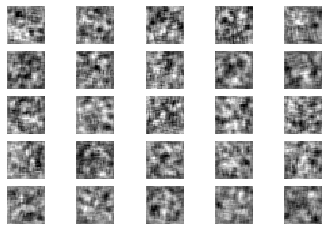

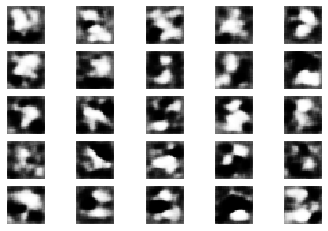

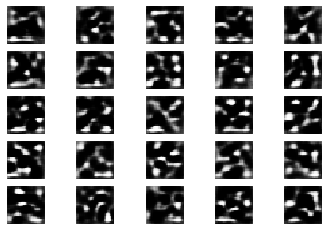

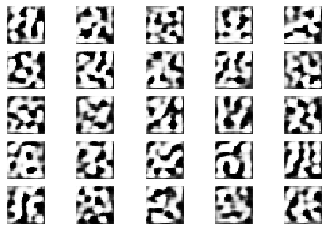

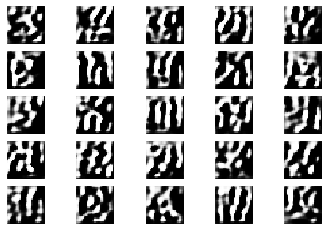

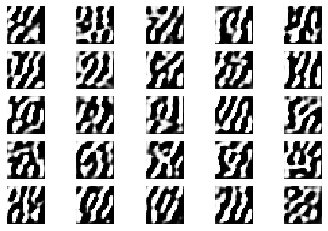

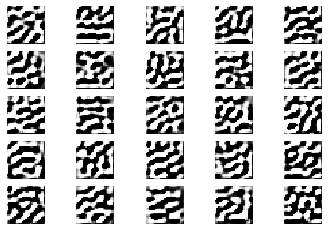

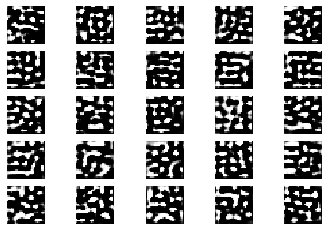

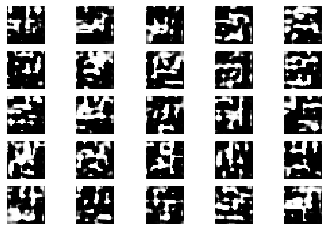

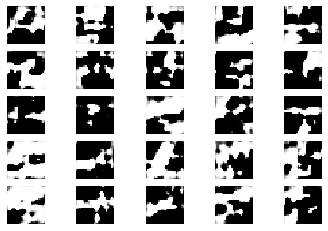

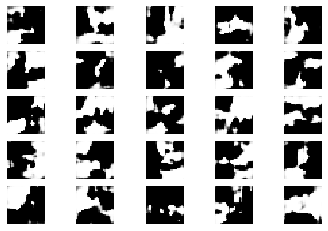

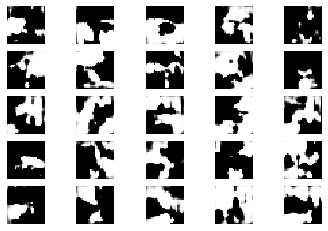

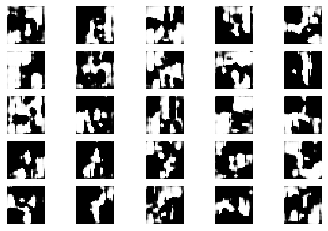

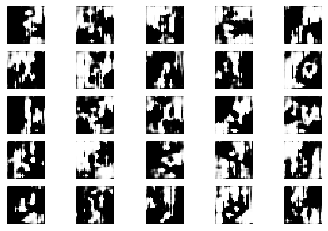

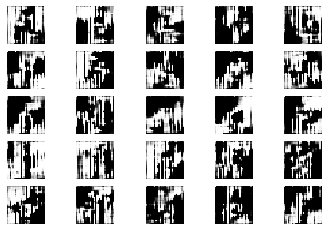

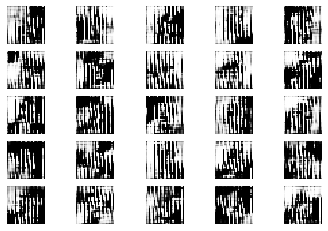

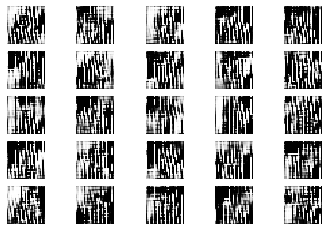

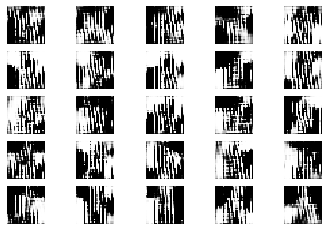

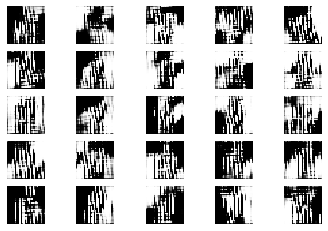

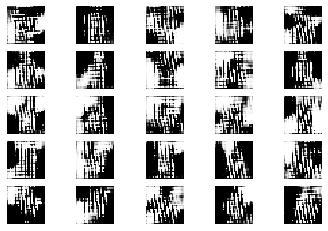

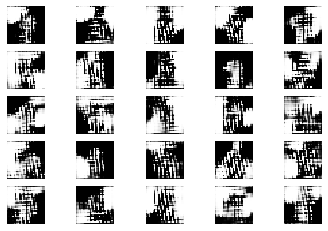

In [18]:
from datetime import datetime
start = datetime.now()

#신경망을 실행시키는 함수를 만듭니다.
def gan_train(epoch, batch_size, saving_interval):

  # MNIST 데이터 불러오기
  (X_train, _), (_, _) = mnist.load_data()  
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
  X_train = (X_train - 127.5) / 127.5  
  print(X_train.shape)   # (60000, 28, 28, 1)

  true = np.ones((batch_size, 1))   # 실제 이미지는 1로 라벨링 
  fake = np.zeros((batch_size, 1))  # 가짜 이미지는 0으로 라벨링

  for i in range(epoch):
        # [1] 실제 데이터를 판별자에 입력하는 부분입니다.
        idx = np.random.randint(0, X_train.shape[0], batch_size)    
        imgs = X_train[idx]  
        # print(imgs.shape)   # (32, 28, 28, 1)  
        d_loss_real = discriminator.train_on_batch(imgs, true)

        # [2] 가상 이미지를 판별자에 입력하는 부분입니다.
        noise = np.random.normal(0, 1, (batch_size, 100))   
        # print(noise.shape)  # (32, 100)
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

        #판별자와 생성자의 오차를 계산합니다.
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) # 판별자 오차
        g_loss = gan.train_on_batch(noise, true)        
        print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

        if i % saving_interval == 0:
            # saving_interval 마다 이미지를 출력한다.
            noise = np.random.normal(0, 1, (25, 100))
              # print(noise.shape)  # (25, 100)
            gen_imgs = generator.predict(noise)
              # print(gen_imgs.shape)   # (25, 28, 28, 1)
            
            gen_imgs = 0.5 * gen_imgs + 0.5
              # Rescale images 0 - 1

            fig, axs = plt.subplots(5, 5)
            count = 0
            for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off') # axis를 제거한다.
                      count += 1
            # fig.savefig("E:\\nmb\\gan_image/gan_mnist_%d.png" % i)

epochs = 401
gan_train(epochs, 32, 20)